In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
print("Using Device:", device)

Using Device: cpu


In [2]:
class DQN(nn.Module):


    def __init__(self, state_space_dim=4, action_space_dim=3):
        super(DQN, self).__init__()

        self.lin1 = nn.Linear(state_space_dim,64)
        self.lin2 = nn.Linear(64,128)
        self.lin3 = nn.Linear(128,256)
        self.lin4 = nn.Linear(256,128)
        self.lin5 = nn.Linear(128,64)
        self.lin6 = nn.Linear(64, action_space_dim)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = F.relu(self.lin5(x))
        x = self.lin6(x)
        return x


In [3]:
obs_feat = 4
act_feat = 3

main_nn = DQN(obs_feat, act_feat)#.to(device)
target_nn = DQN(obs_feat, act_feat)#.to(device)

optimizer = torch.optim.RMSprop(main_nn.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

In [4]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size, device="cpu"):
    """Initializes the buffer."""
    self.buffer = deque(maxlen=size)
    self.device = "cpu"#device

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = torch.as_tensor(np.array(states), device=self.device)
    actions = torch.as_tensor(np.array(actions), device=self.device)
    rewards = torch.as_tensor(
        np.array(rewards, dtype=np.float32), device=self.device
    )
    next_states = torch.as_tensor(np.array(next_states), device=self.device)
    dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
    return states, actions, rewards, next_states, dones

In [5]:
def select_epsilon_greedy_action(state, epsilon):
  """Take random action with probability epsilon, else take best action."""
  result = np.random.uniform()
  if result < epsilon:
    return env.action_space.sample() # Random action (left or right).
  else:
    qs = main_nn(state).cpu().data.numpy()
    return np.argmax(qs) # Greedy action for state.

In [6]:
def train_step(states, actions, rewards, next_states, dones):
  """Perform a training iteration on a batch of data sampled from the experience
  replay buffer.
  """
  # Calculate targets.
  max_next_qs = target_nn(next_states).max(-1).values
  target = rewards + (1.0 - dones) * discount * max_next_qs
  qs = main_nn(states)
  action_masks = F.one_hot(actions, act_feat)
  masked_qs = (action_masks * qs).sum(dim=-1)
  loss = loss_fn(masked_qs, target.detach())
  #nn.utils.clip_grad_norm_(loss, max_norm=10)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [7]:
def transformState(S_t):
    return [ math.atan2( S_t[0], S_t[1]), math.atan2( S_t[2], S_t[3]), S_t[4], S_t[5] ]


In [8]:
# Hyperparameters.
num_episodes = 1000
epsilon = 1.0
batch_size = 50
discount = 0.99
buffer = ReplayBuffer(100000, device=device)
cur_frame = 0

env = gym.make('Acrobot-v1')

# Start training. Play game once and then train with a batch.
last_100_ep_rewards = []
for episode in range(num_episodes+1):
  state = np.array(transformState(env.reset()[0])).astype(np.float32)
  ep_reward, done = 0, False

  if episode % 50 == 0:
      target_nn.load_state_dict(main_nn.state_dict())

  for t in range(1000):
    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_epsilon_greedy_action(state_in, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    next_state = np.array(transformState(next_state)).astype(np.float32)
    ep_reward += reward
    # Save to experience replay.
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1
    # Copy main_nn weights to target_nn.
    
    # Train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones)
    if done:
      break

  if episode < 950:
    epsilon -= 0.001

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  if episode % 50 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.2f}')
    
env.close()

Episode 0/1000. Epsilon: 0.999. Reward in last 100 episodes: -1000.00
Episode 50/1000. Epsilon: 0.949. Reward in last 100 episodes: -960.78
Episode 100/1000. Epsilon: 0.899. Reward in last 100 episodes: -944.63
Episode 150/1000. Epsilon: 0.849. Reward in last 100 episodes: -947.99


KeyboardInterrupt: 

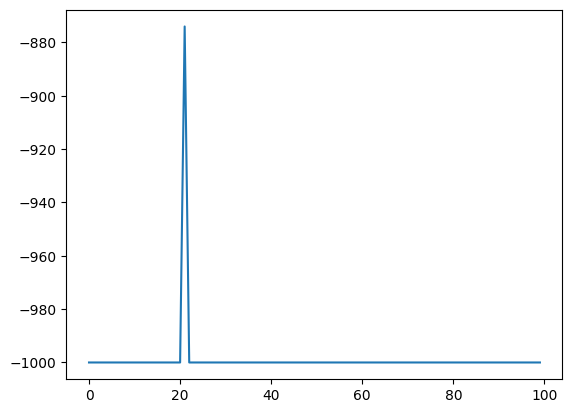

In [10]:
plt.figure()
plt.plot(last_100_ep_rewards)
plt.show()